Code for the figures, where an image is restored from a fraction of pixels (fig. 7 bottom, fig. 14 of supmat).

In [1]:
# Mounting my Google Drive and set the cwd on my dataset
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd /content/drive/My Drive/DIP

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive/DIP


# Import libs

In [0]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models import *
#from models.resnet import ResNet
#from models.unet import UNet
#from models.skip import skip
#from models import get_net
import torch
import torch.optim
from skimage.measure import compare_psnr

from utils.inpainting_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize=-1
dim_div_by = 64
dtype = torch.cuda.FloatTensor

# Choose figure

torch.Size([1, 1, 514, 514])


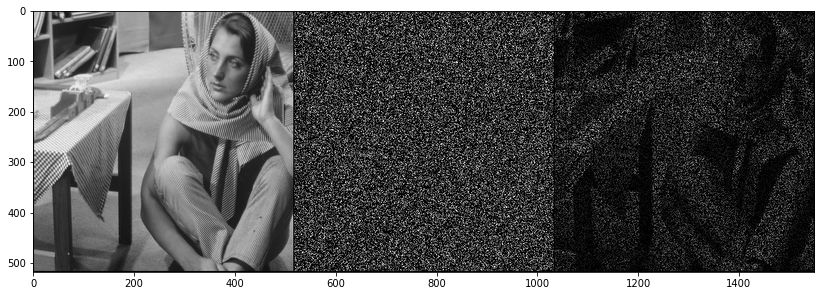

(1, 514, 514)
(1, 514, 514)


In [3]:
# fig. 7 (bottom)
f = './data2/restoration/barbara.png'

# fig. 14 of supmat
#f = './data2/restoration/kate.png'

#f = './data2/restoration/cat.png'

#img_pil, img_np = get_image(f, imsize) #originale

img_pil = crop_image(get_image(f, imsize)[0], d=64)
img_np = pil_to_np(img_pil)

if 'barbara' in f:
    img_np = nn.ReflectionPad2d(1)(np_to_torch(img_np))[0].numpy()
    img_pil = np_to_pil(img_np)
    
    img_mask = get_bernoulli_mask(img_pil, 0.80)
    img_mask_np = pil_to_np(img_mask)
elif 'cat' in f:
    img_mask = get_bernoulli_mask(img_pil, 0.50)

    img_mask_np = pil_to_np(img_mask)
    img_mask_np[1] = img_mask_np[0]
    img_mask_np[2] = img_mask_np[0]
else:
    assert False
    

img_masked = img_np * img_mask_np

mask_var = np_to_torch(img_mask_np).type(dtype)
print(mask_var.shape)

plot_image_grid([img_np, img_mask_np, img_mask_np * img_np], 3,11);

print(img_np.shape)
print(img_mask_np.shape)


# Set up everything

In [4]:
show_every=500
figsize=5
pad = 'reflection' # 'zero'
INPUT = 'noise'
input_depth = 32
OPTIMIZER = 'adam'
OPT_OVER =  'net'
if 'barbara' in f:
    OPTIMIZER = 'adam'
    
    LR = 0.001
    num_iter = 5000
    reg_noise_std = 0.03
    
    NET_TYPE = 'skip'
    net = get_net(input_depth, 'skip', pad, n_channels=1,
                  skip_n33d=128, 
                  skip_n33u=128, 
                  skip_n11=4, 
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)
elif 'cat' in f:
    OPT_OVER = 'net'
    num_iter = 10000
    LR = 0.01
    reg_noise_std = 0.00
        
    net = skip(input_depth, 
               img_np.shape[0], 
               num_channels_down = [16, 32, 64, 128, 128],
               num_channels_up   = [16, 32, 64, 128, 128],
               num_channels_skip =    [0, 0, 0, 0, 0],   
               filter_size_down = 3, filter_size_up = 3, filter_skip_size=1,
               upsample_mode='bilinear', 
               downsample_mode='avg',
               need_sigmoid=True, need_bias=True, pad=pad).type(dtype)
    
# Loss
mse = torch.nn.MSELoss().type(dtype)
img_var = np_to_torch(img_np).type(dtype)
print(img_var.shape)

net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype).detach()
print(net_input.shape)

torch.Size([1, 1, 514, 514])
torch.Size([1, 32, 514, 514])


# Main loop

Starting optimization with ADAM


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  from ipykernel import kernelapp as app


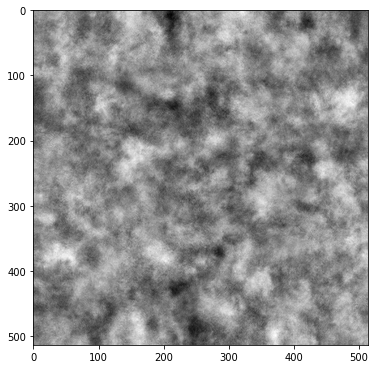

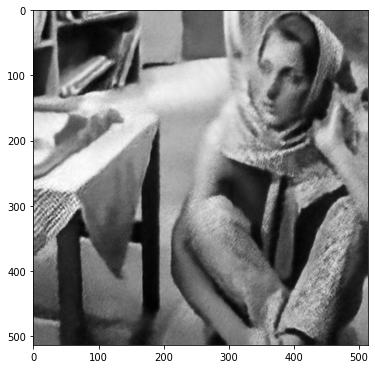

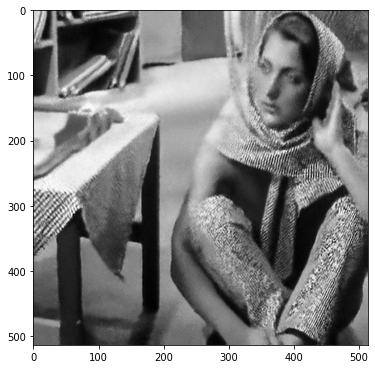

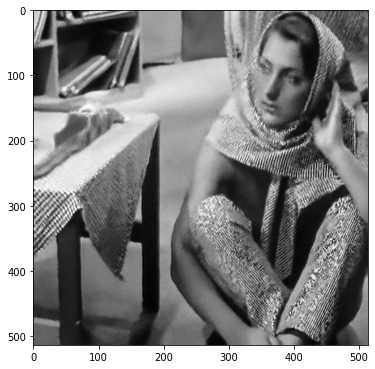

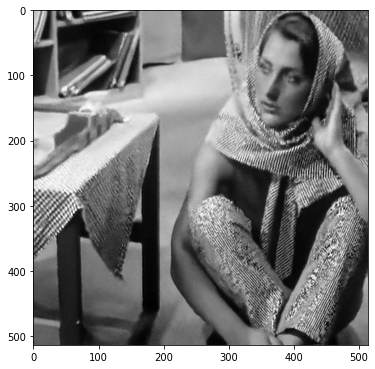

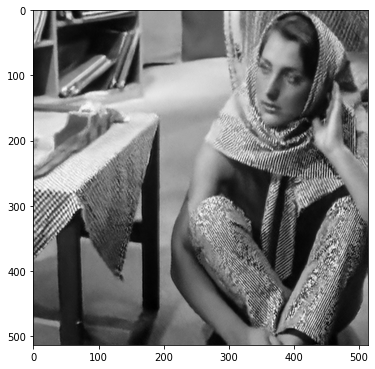

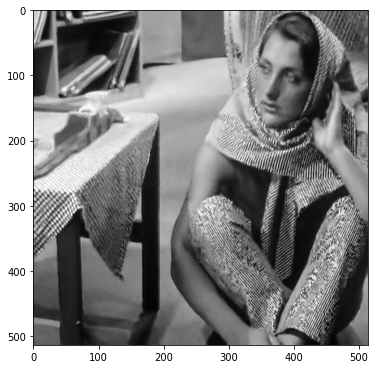

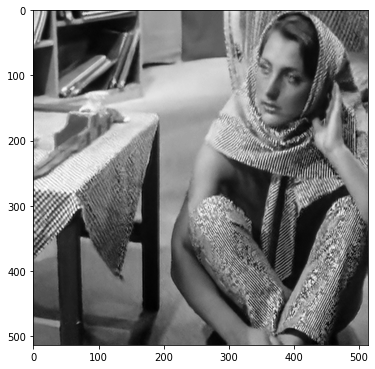

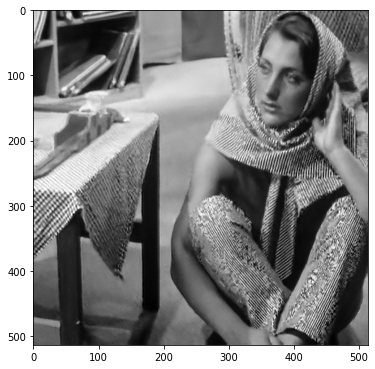

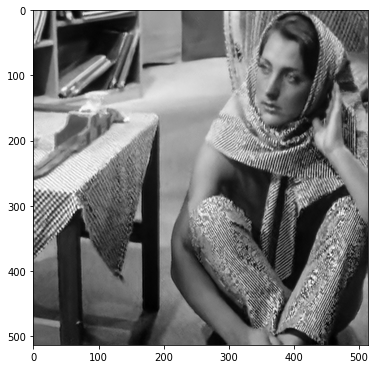

In [5]:
def closure():

    global i, psrn_masked_last, last_net, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
    #print(out.shape)

    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
    
    psrn_masked = compare_psnr(img_masked, out.detach().cpu().numpy()[0] * img_mask_np) 
    psrn = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 

    print ('Iteration %05d    Loss %f PSNR_masked %f PSNR %f' % (i, total_loss.item(), psrn_masked, psrn),'\r', end='')
    
    
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        
        # Backtracking
        if psrn_masked - psrn_masked_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.cpu() for x in net.parameters()]
            psrn_masked_last = psrn_masked



        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)

    i += 1

    return total_loss

# Init globals 
last_net = None
psrn_masked_last = 0
i = 0

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

# Run
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR=LR, num_iter=num_iter)

In [6]:
out_np = torch_to_np(net(net_input))
q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);
q = plot_image_grid([np.clip(img_mask_np * img_np, 0, 1), img_np], factor=13);
q = plot_image_grid([np.clip(img_mask_np, 0, 1), img_np], factor=13);
#plot_image_grid([img_np, img_mask_np, img_mask_np * img_np], 3,11);
plot_image_grid([np.clip(out_np, 0, 1), img_mask_np, img_mask_np * img_np], 3,11);



Output hidden; open in https://colab.research.google.com to view.